In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/arjbargav/DS_assignments/refs/heads/main/Time%20Series/exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
# Check missing values
df.isna().sum()

,0
date,0
Ex_rate,0


In [4]:
# Convert the 'date' column to datetime format with the correct format
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M")

In [5]:
# Set the 'date' column as the index
df.set_index('date', inplace=True)

In [6]:
# Upsampling
upsampled = df.resample('D').mean()
upsampled

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


<Axes: xlabel='date'>

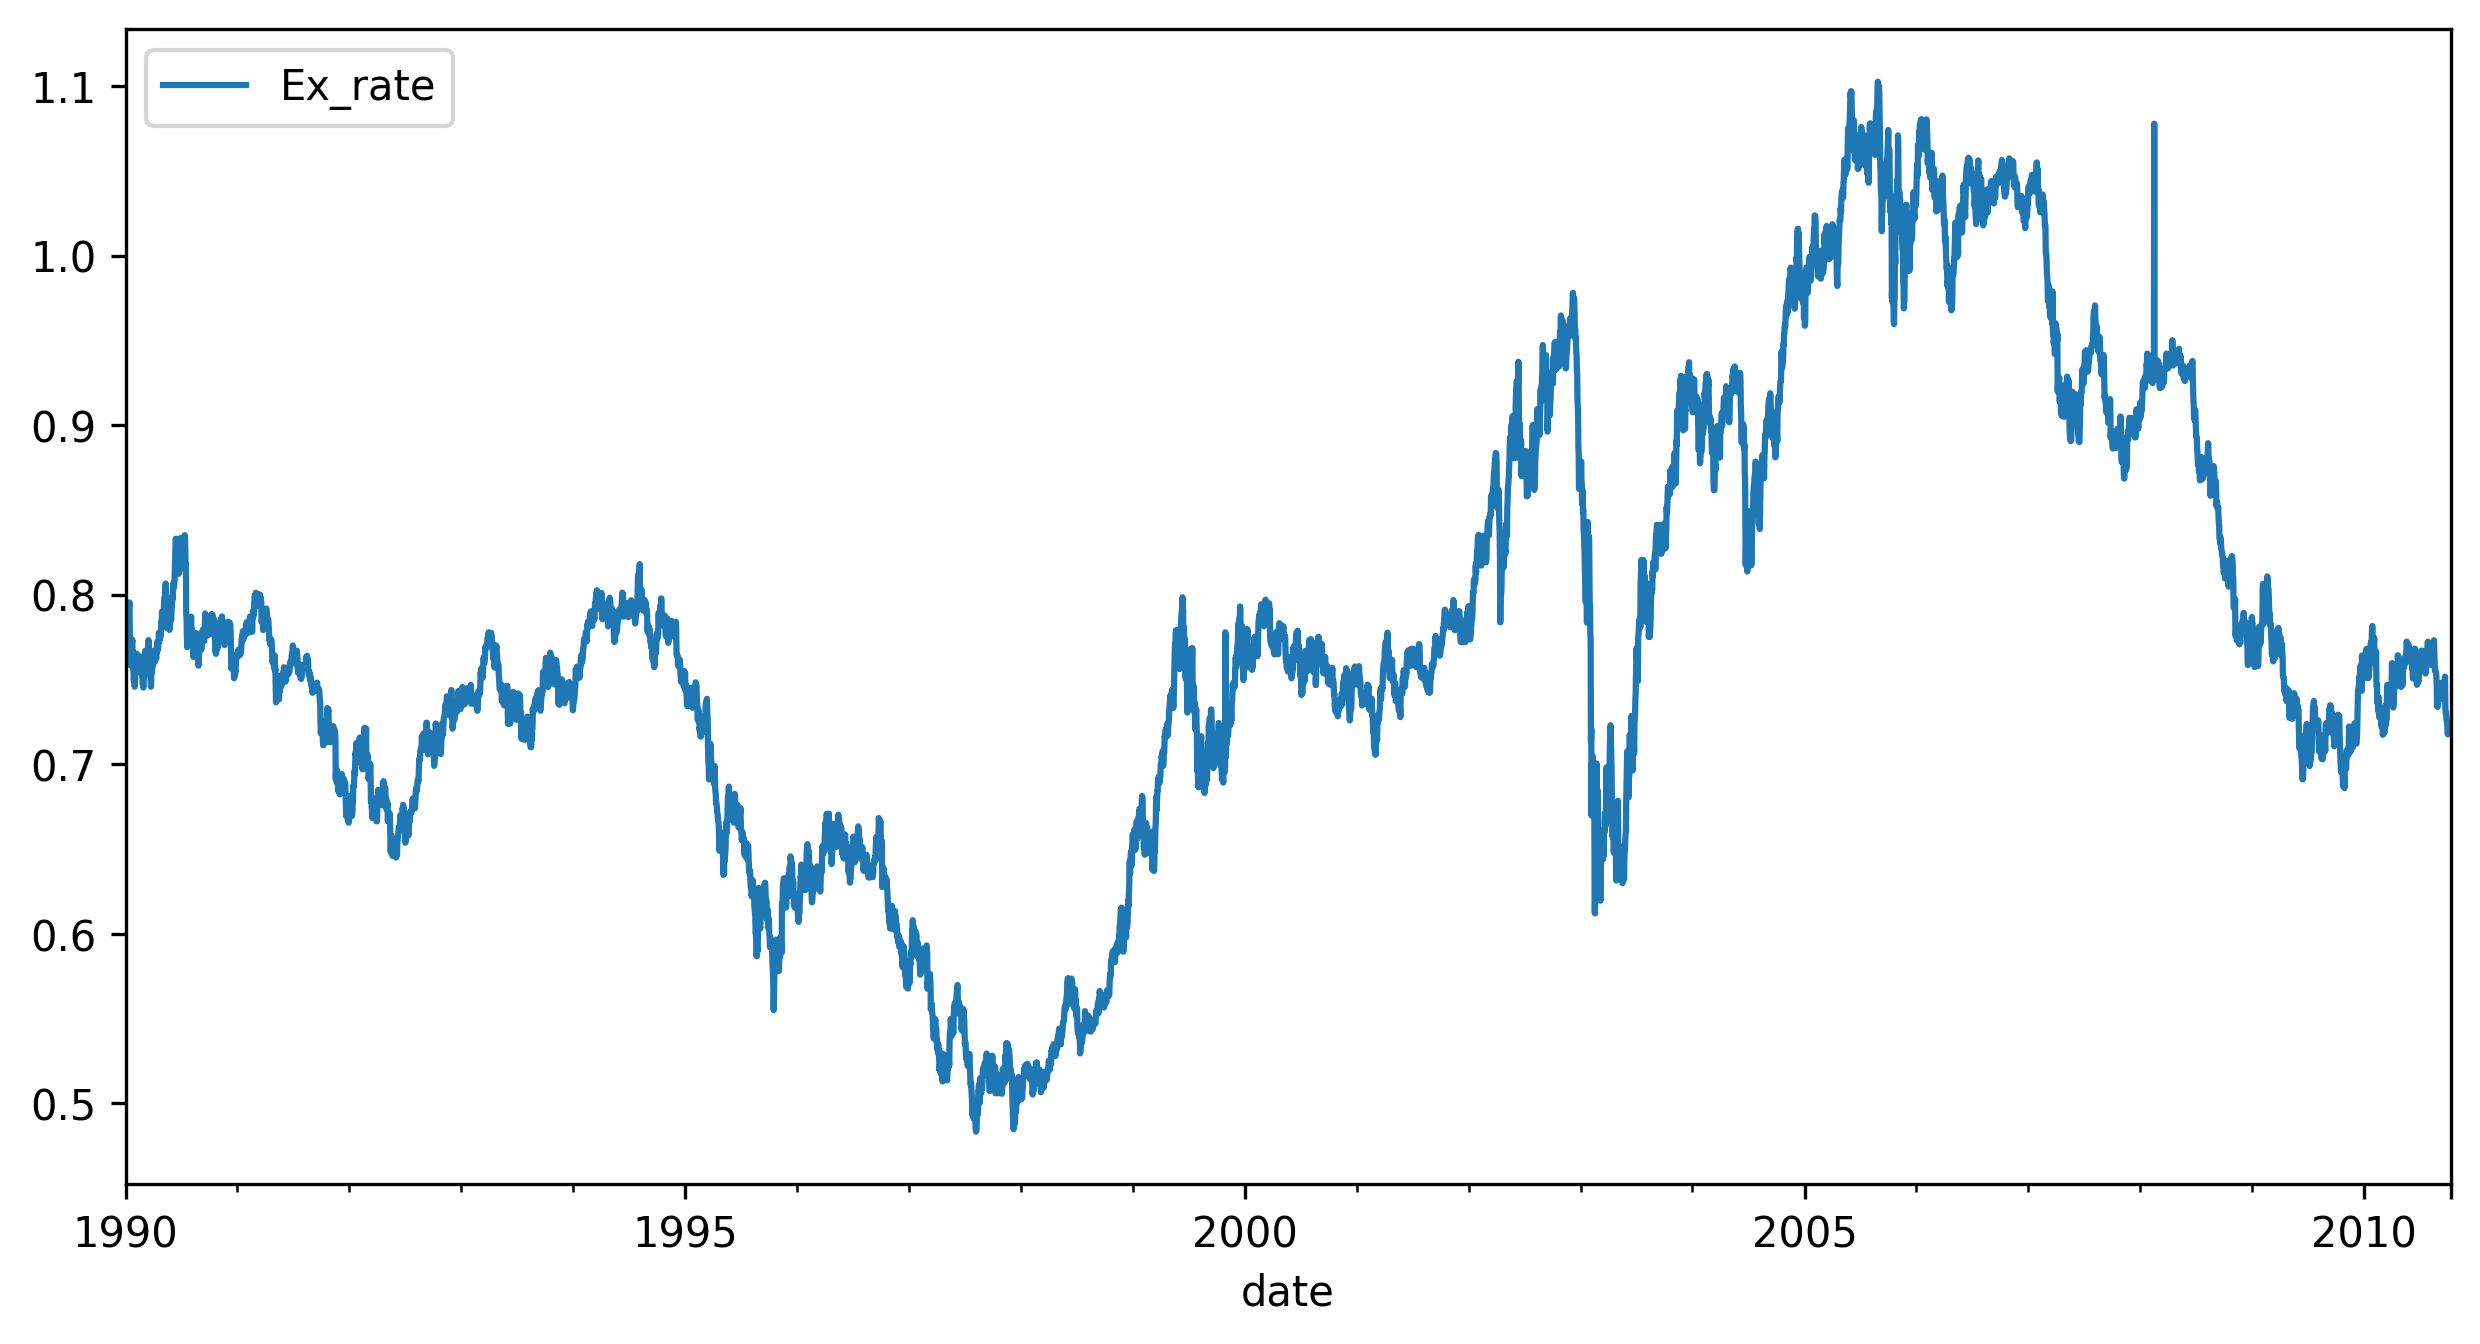

In [7]:
# Upsamle plot
upsampled.plot()

In [8]:
# Downsampling
downsampled = df.resample('Q').mean()
downsampled

,Ex_rate
date,
1990-03-31,0.764122
1990-06-30,0.792053
1990-09-30,0.785475
1990-12-31,0.774154
1991-03-31,0.783332
...,...
2009-12-31,0.719797
2010-03-31,0.746596
2010-06-30,0.755990


In [9]:
downsampled.shape

(84, 1)

<Axes: xlabel='date'>

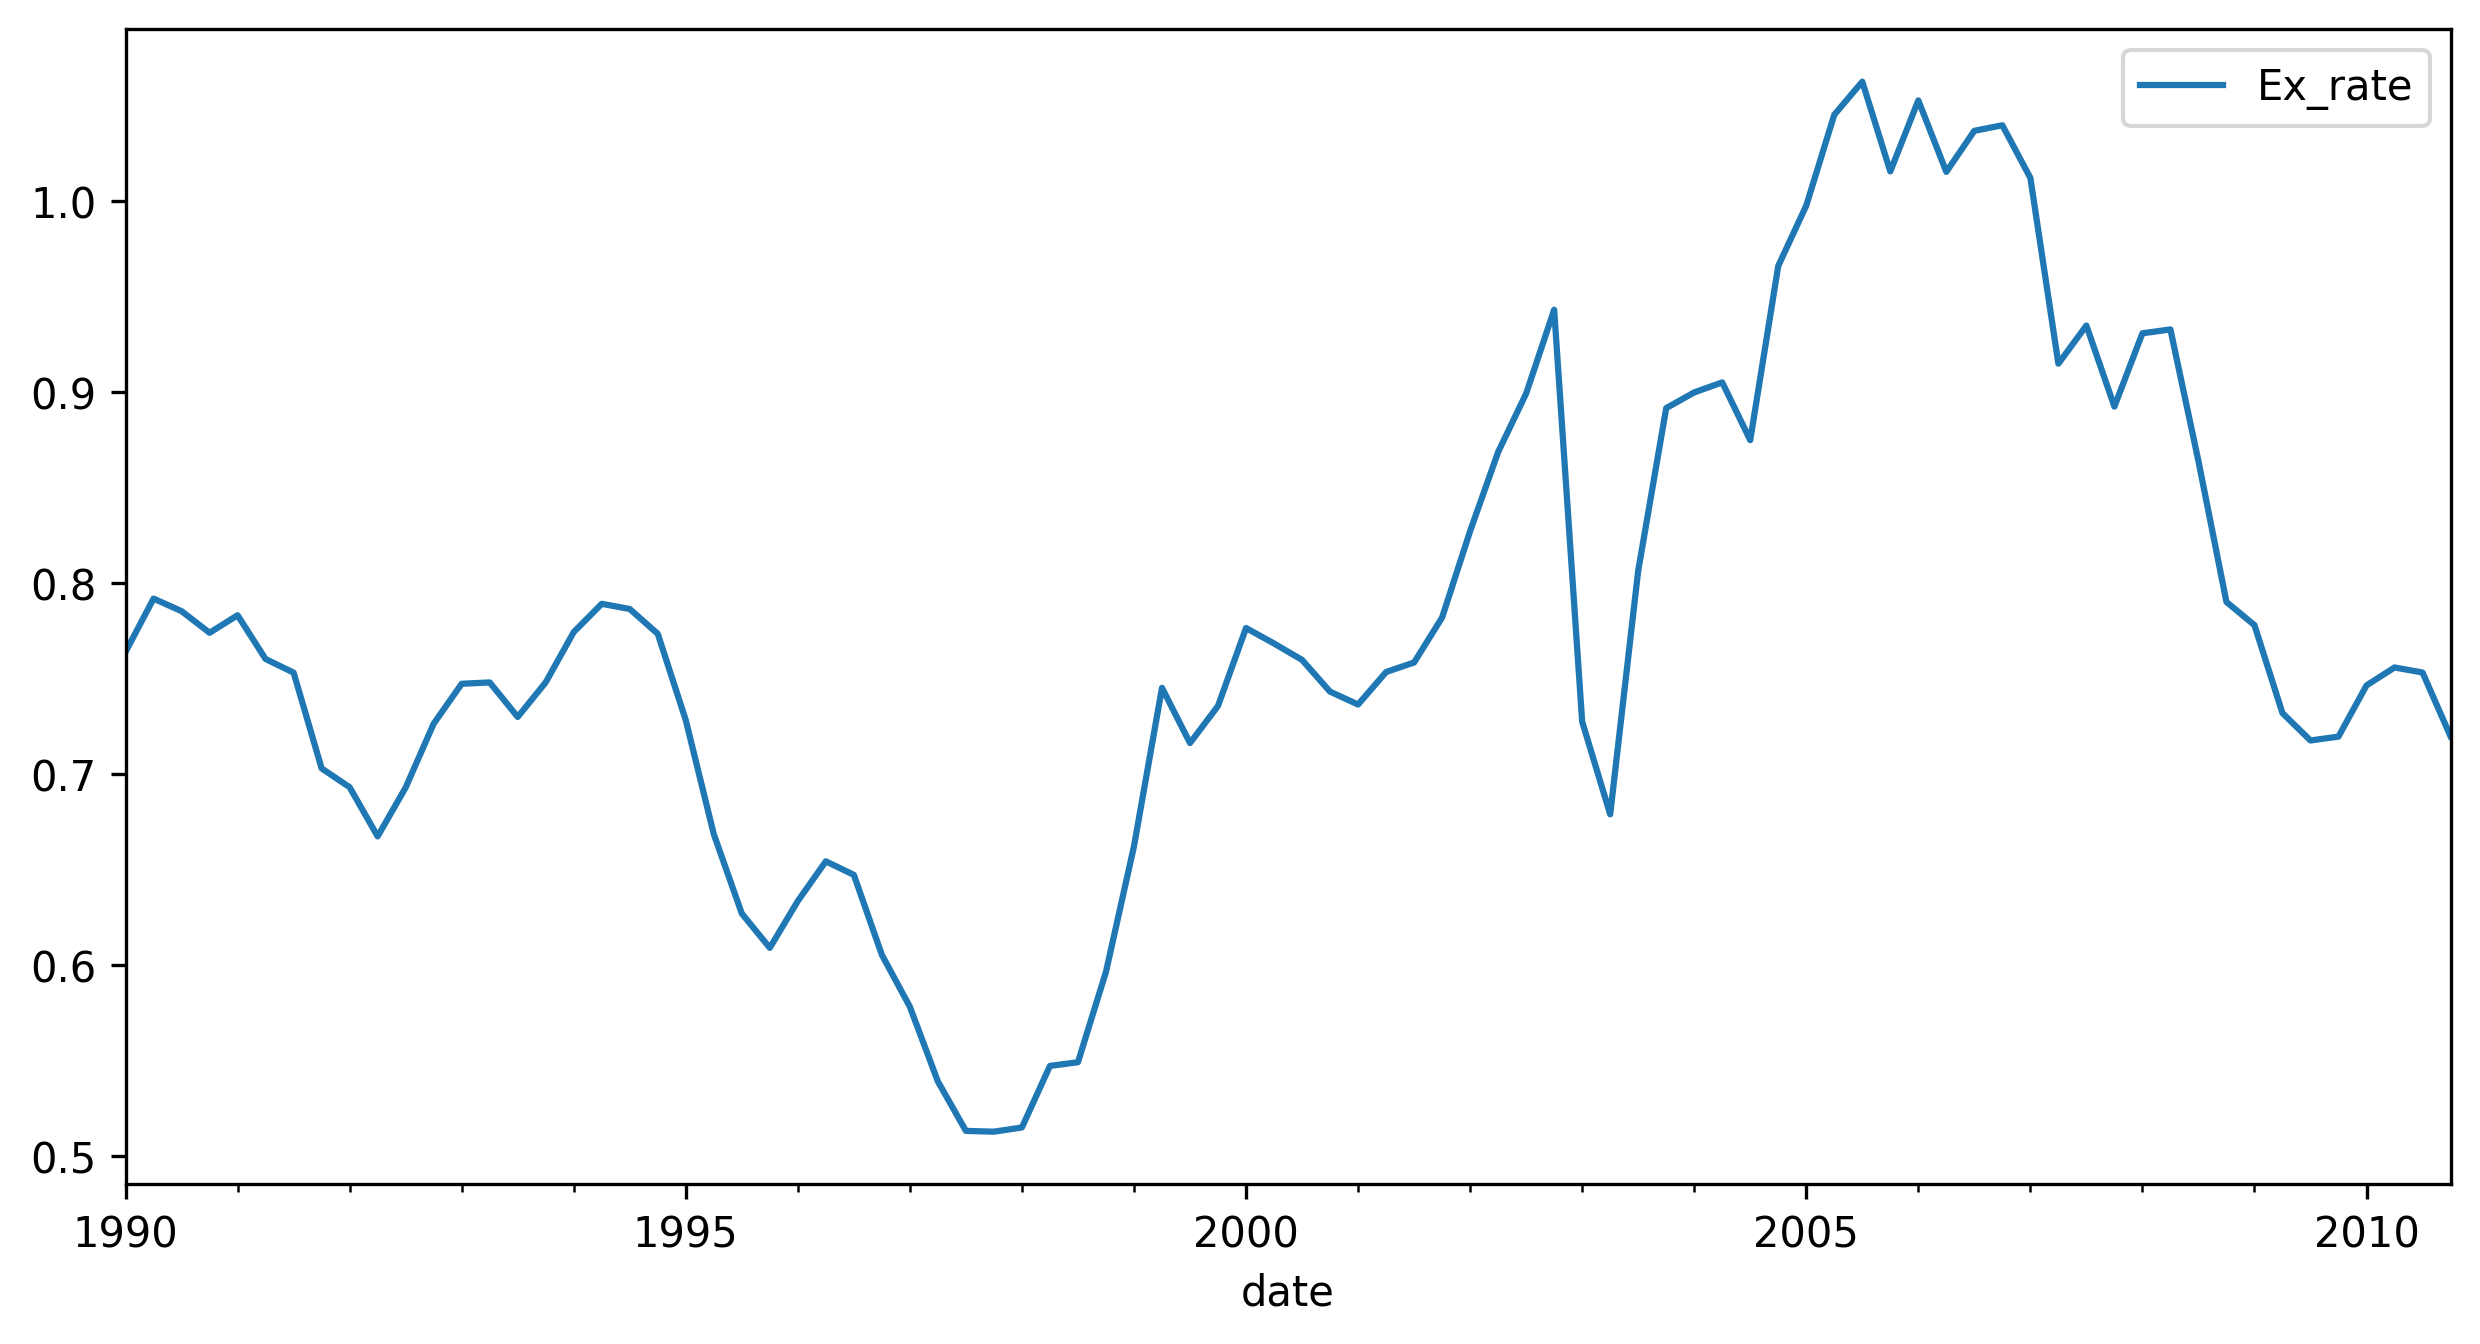

In [10]:
# Downsampled plot
downsampled.plot()

In [11]:
df.shape

(7588, 1)

In [12]:
# Train test split by 20%
7588 * 0.2, 7588-(7588 * 0.2)

(1517.6000000000001, 6070.4)

# ARIMA Model building

In [13]:
!pip install statsmodels
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.4 MB/s eta 0:00:00


In [14]:
# Import libraris
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

<Axes: xlabel='date'>

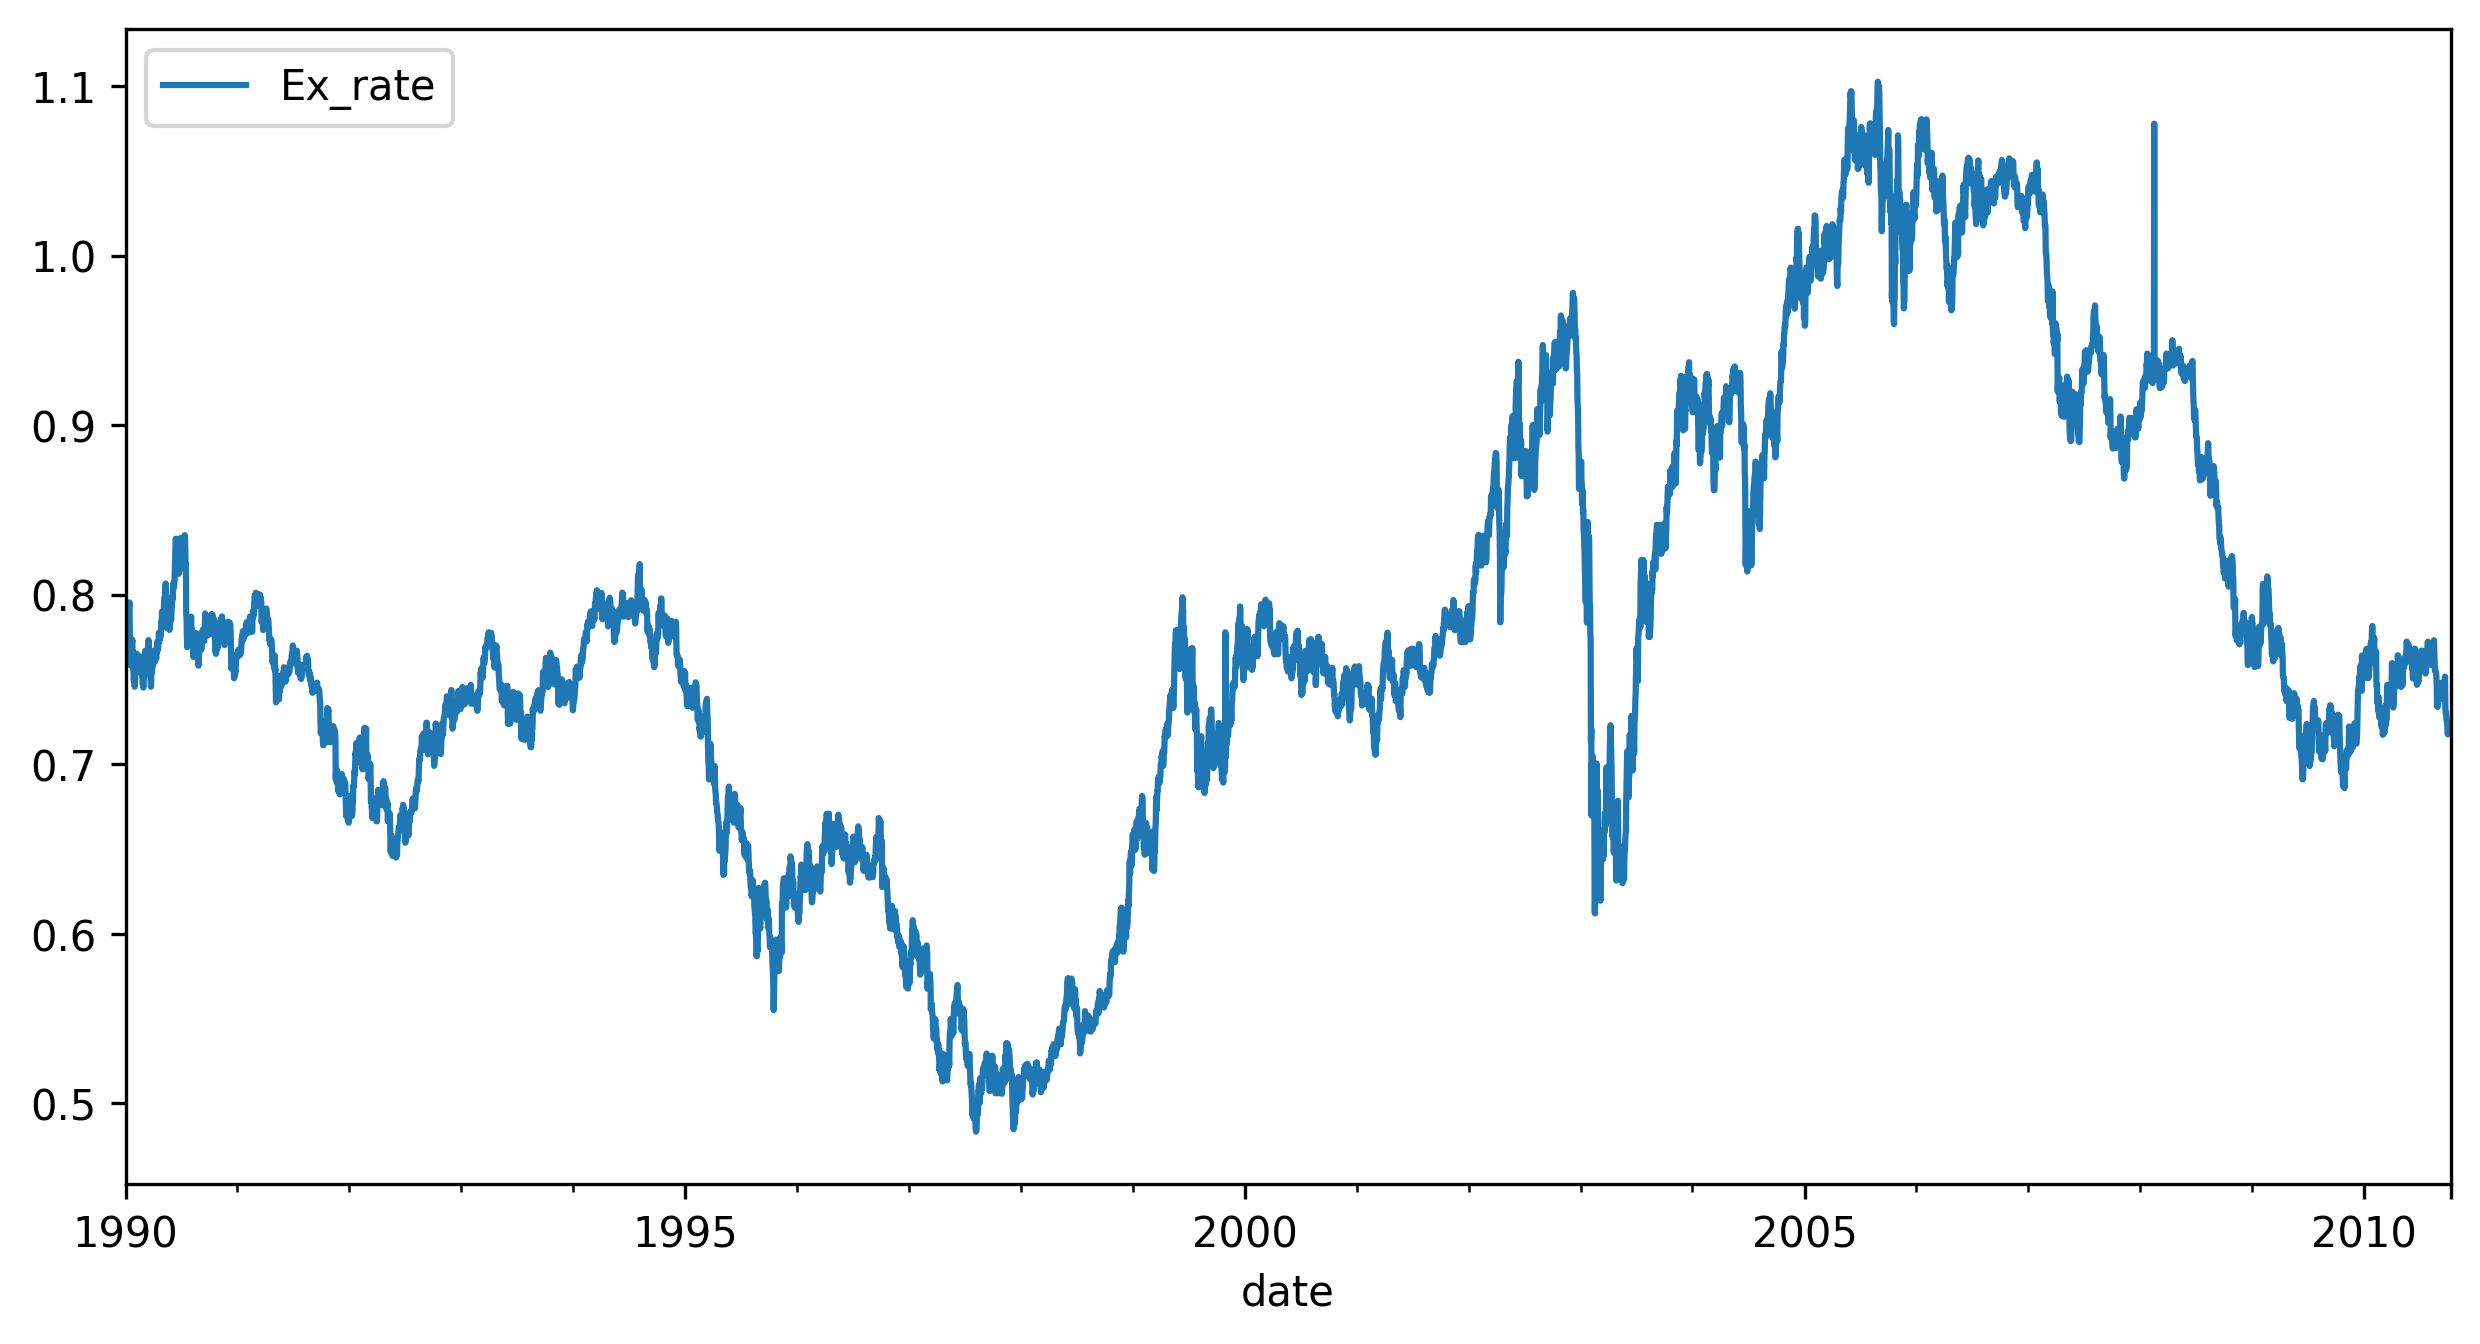

In [15]:
# Check the stationarity of the data
df.plot()

We see that there is a varying mean across the dataset.

In [16]:
# adfuller test
adfuller(df['Ex_rate'])[1]

0.4492327353597477

As per the adfuller test, if p<0.05, then Data is stationary, and if p>0.05, then Data is not stationary.
Here, for p=0.44, which is >0.05, the data is not stationary.

In [17]:
# Convert the non-stationary data into stationary by differencing method
df['First-order'] = df['Ex_rate'].diff(periods=1)

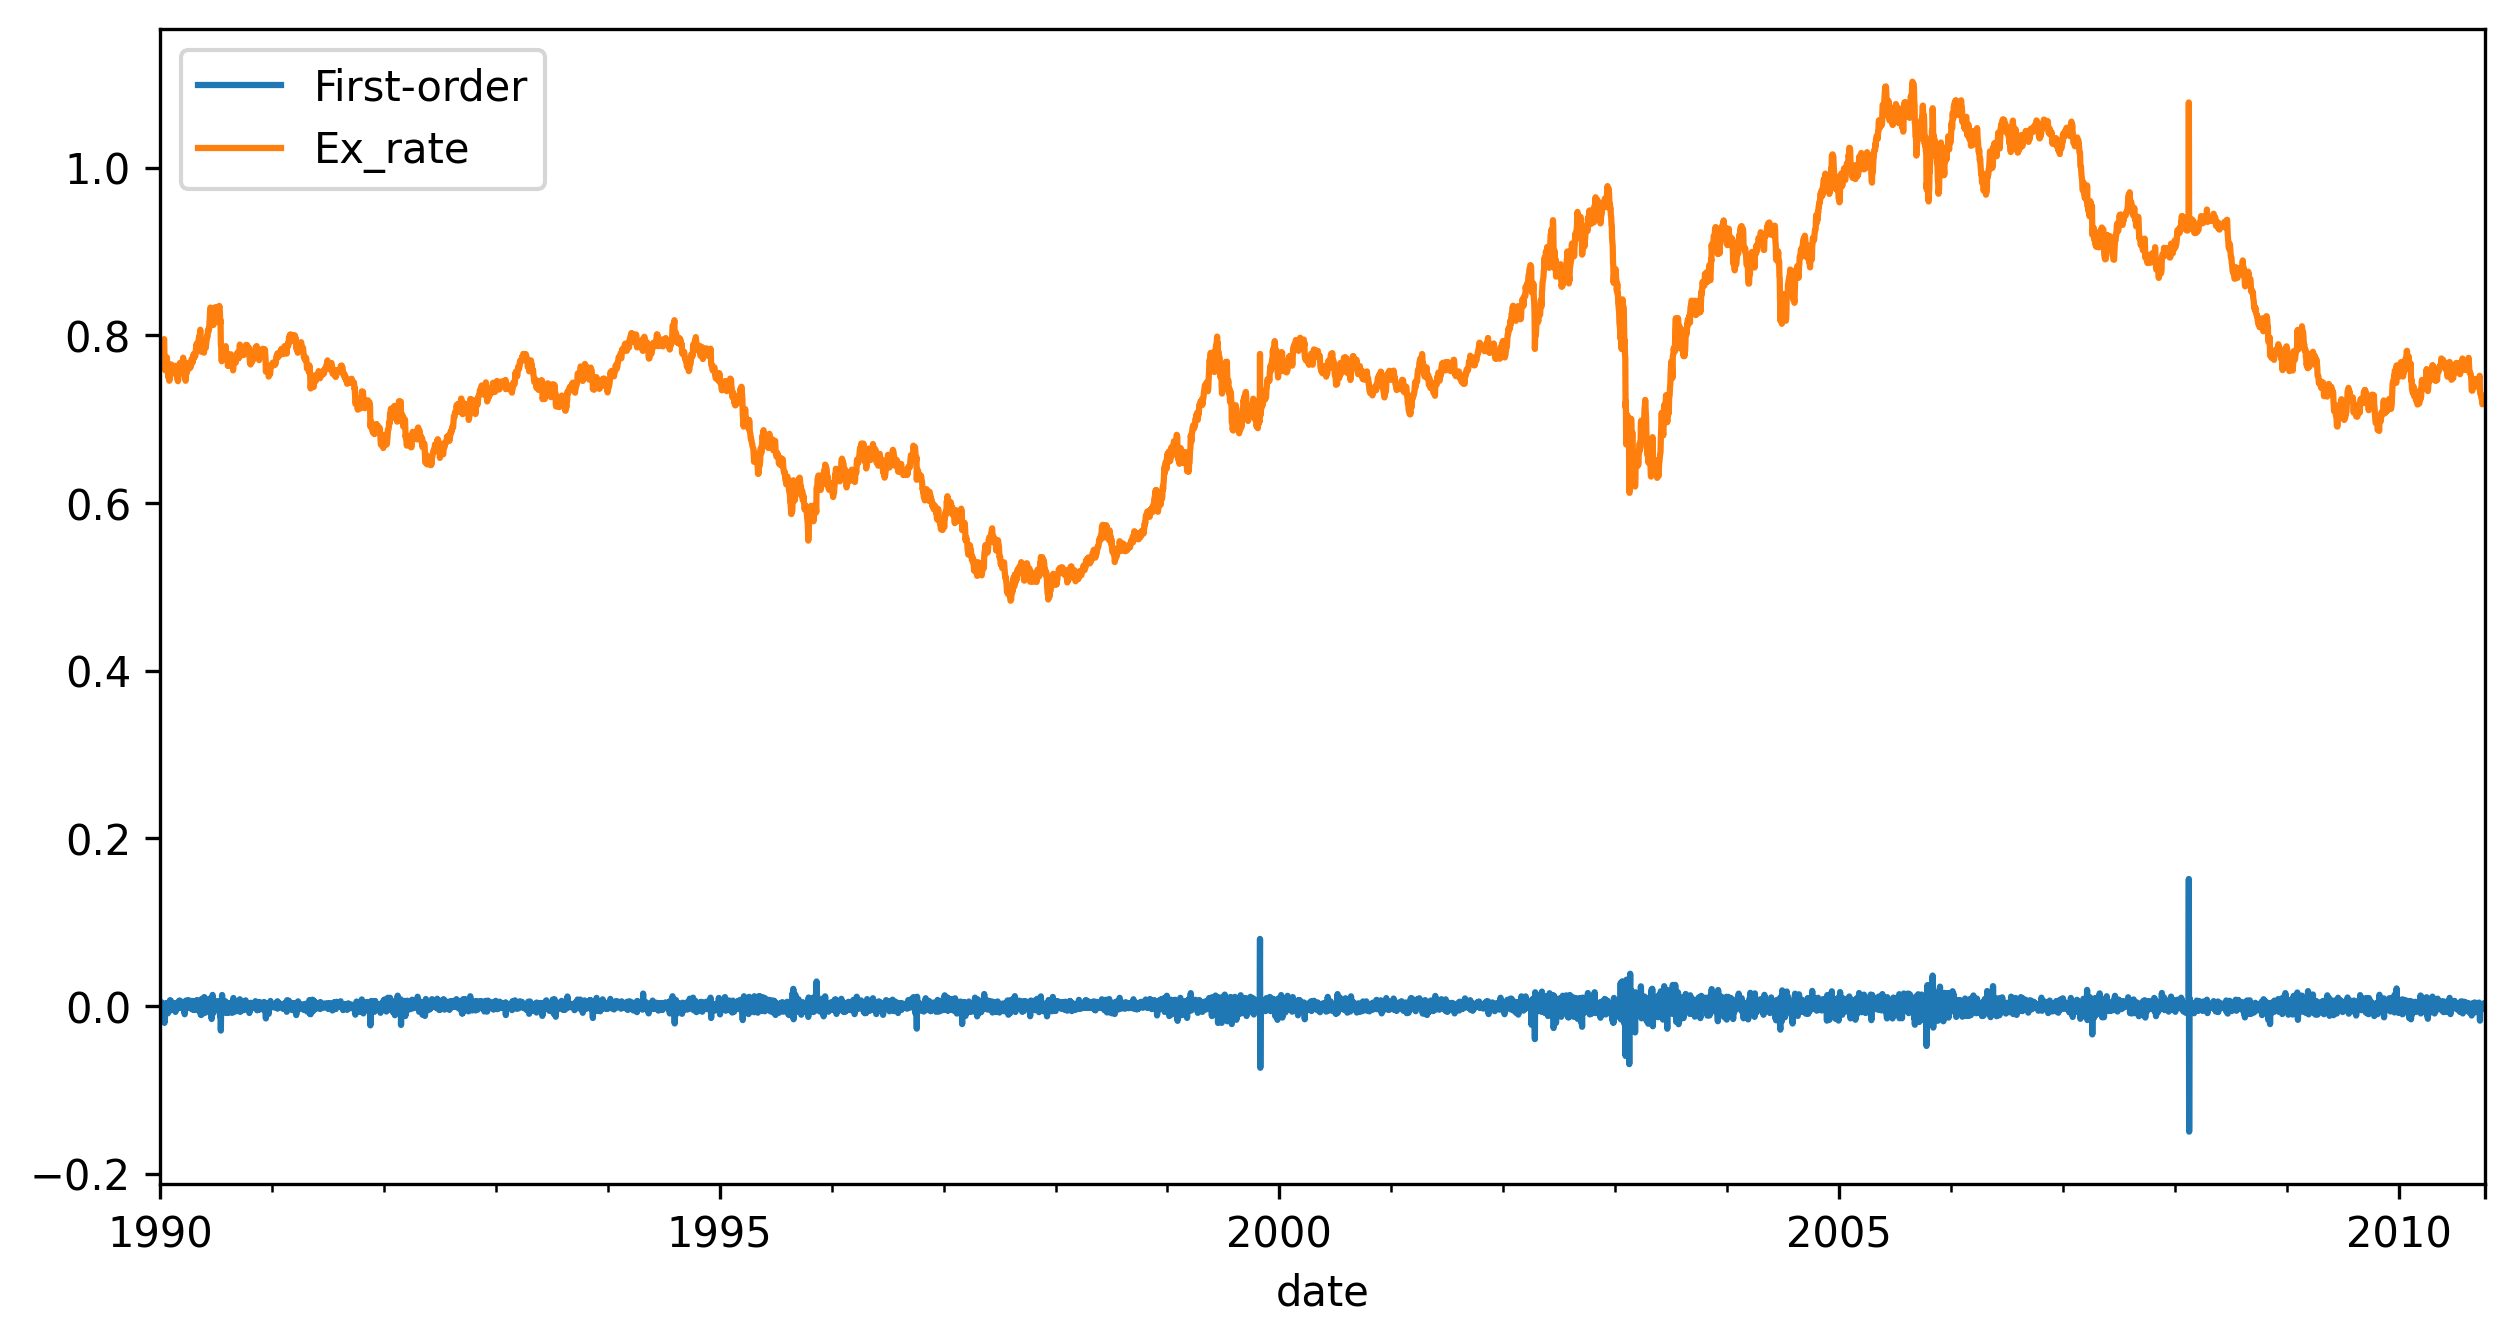

In [18]:
df['First-order'].plot()
df['Ex_rate'].plot()
plt.legend()

In [19]:
# The First-order differencing yields a stationary data.
# Check the adfuller test
adfuller(df['First-order'].dropna())[1]

0.0

Here the values of adfuller test is 0, that is <0.05, Hence the first order data is stationary.

In [20]:
# Find the order of arima
order = auto_arima(df['Ex_rate'].dropna())
order.order

(1, 1, 0)

In [21]:
# Split the data
train = df.head(6070)
test = df.tail(1518)

In [22]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['Ex_rate'], order=(1,1,0)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [23]:
ypred = model.predict(start='2006-08-15 00:00:00', end='2010-10-10 00:00:00')
ypred

,predicted_mean
2006-08-15,1.023543
2006-08-16,1.023543
2006-08-17,1.023543
2006-08-18,1.023543
2006-08-19,1.023543
...,...
2010-10-06,1.023543
2010-10-07,1.023543
2010-10-08,1.023543
2010-10-09,1.023543


In [24]:
print(np.sqrt(mean_squared_error(test['Ex_rate'], ypred)))

0.2053585690039703


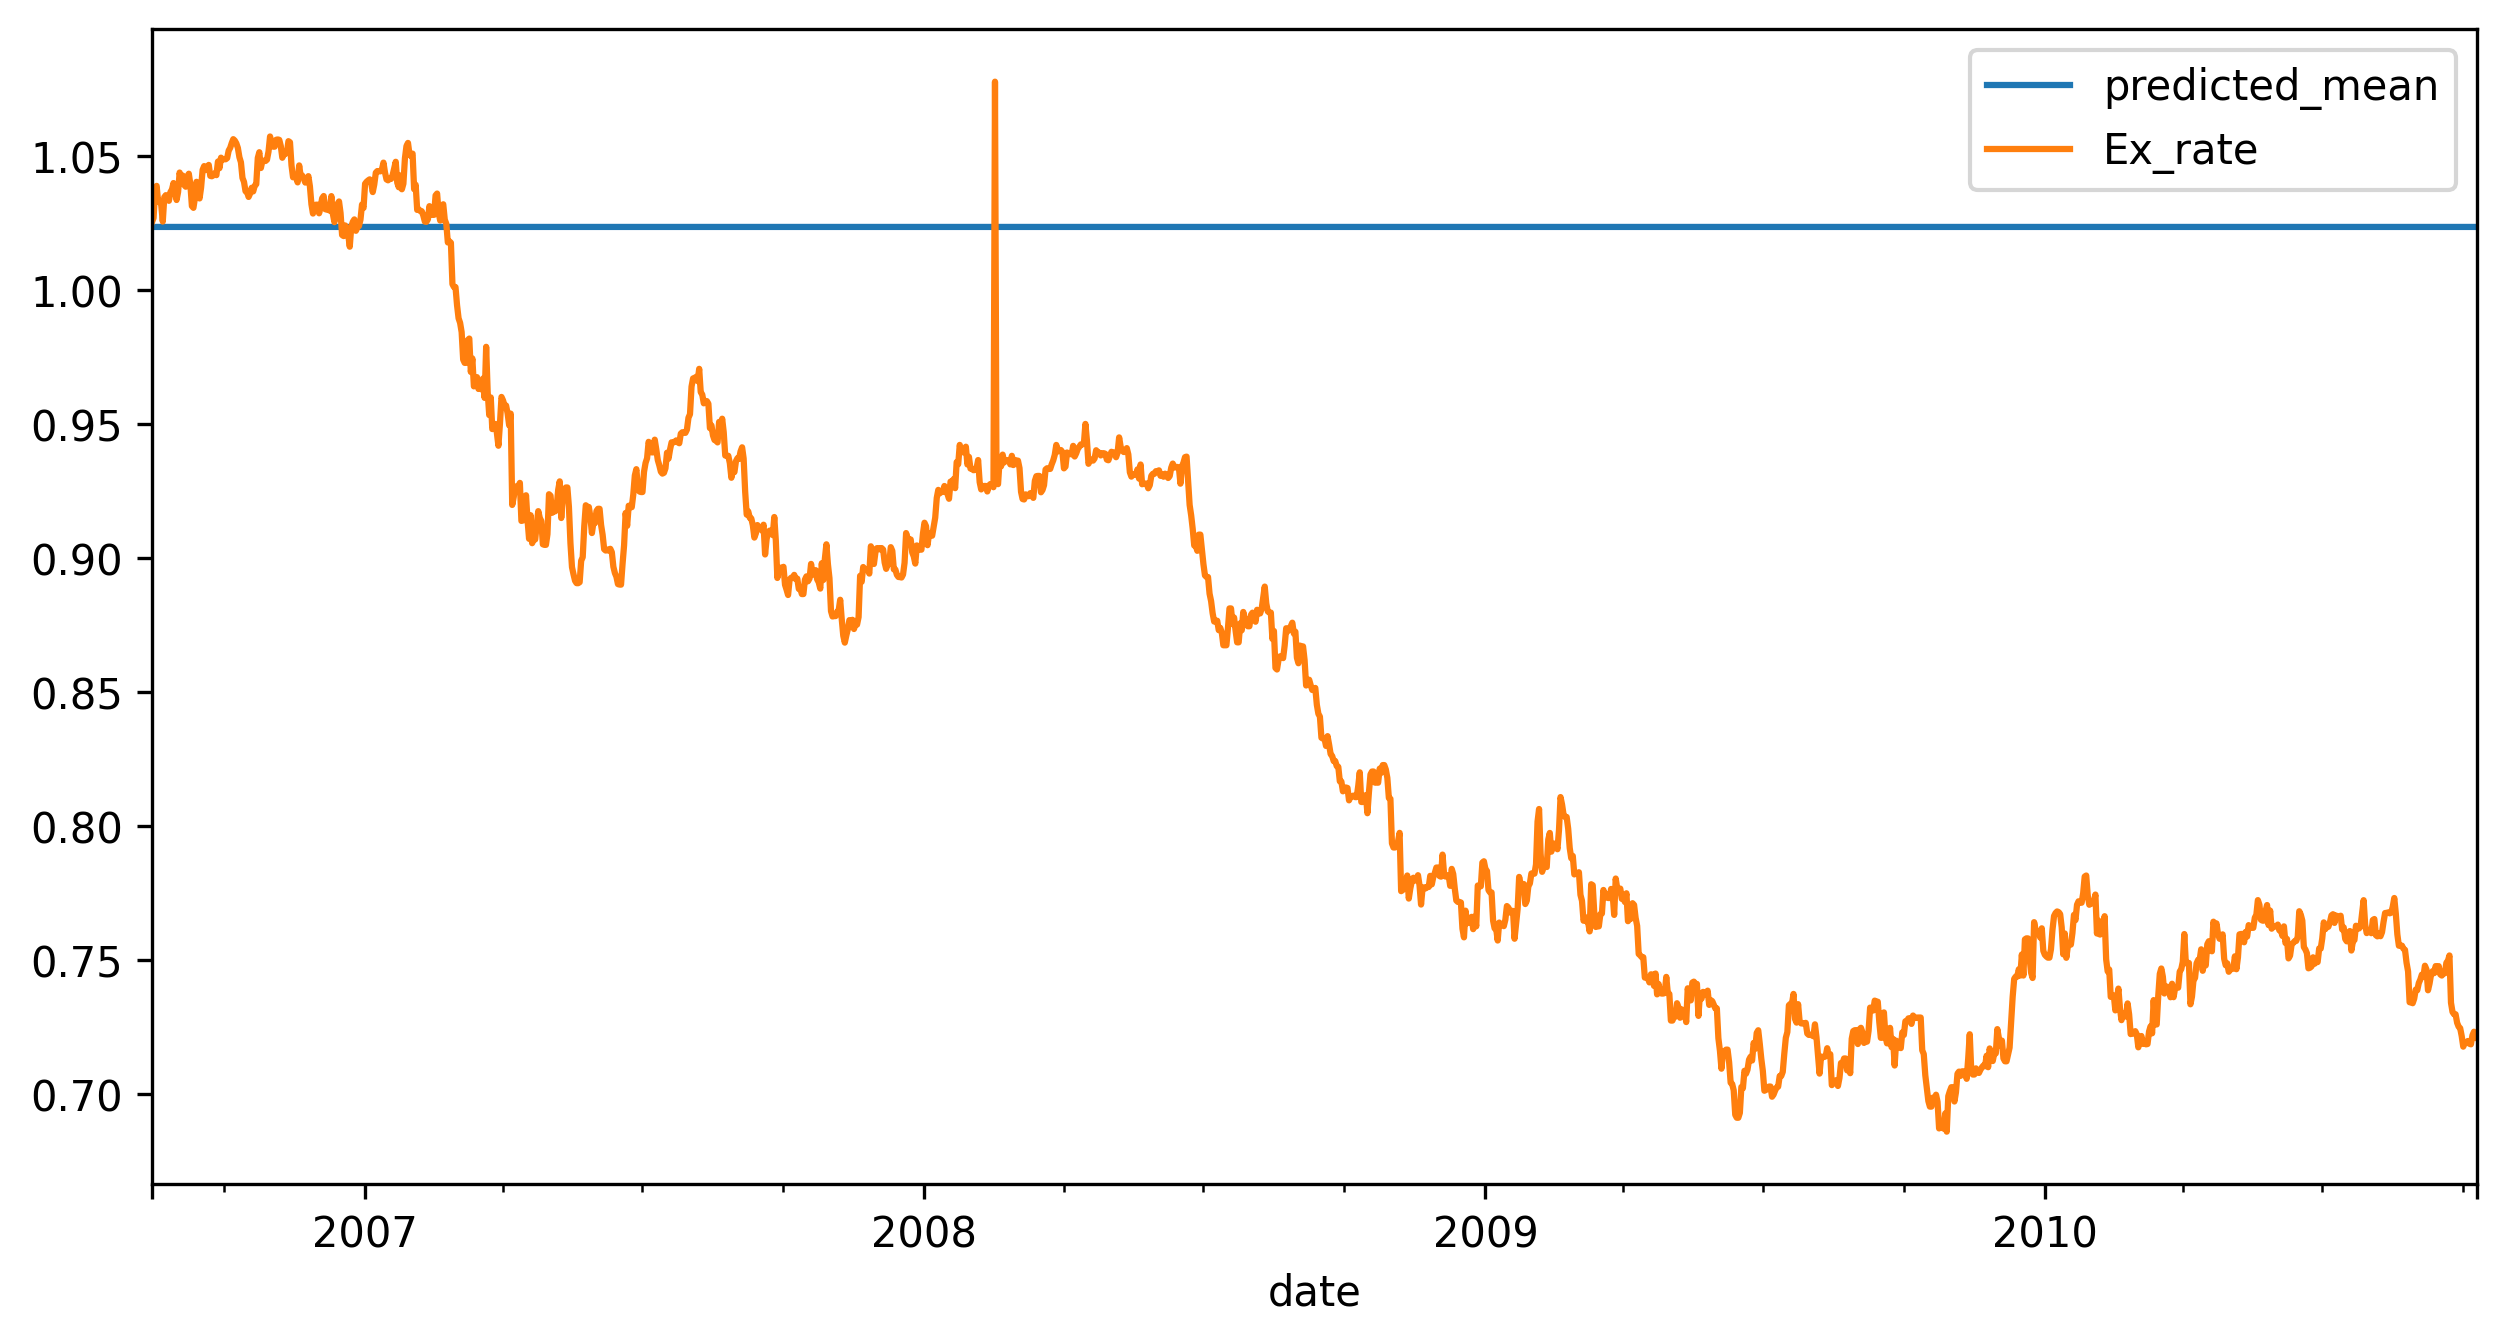

In [25]:
ypred.plot()
test['Ex_rate'].plot()
plt.legend()

# Exponential Smoothing Model

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
# Fit the model
model2 = ExponentialSmoothing(train['Ex_rate'], trend=None, seasonal=None)
model2_fit = model2.fit(smoothing_level=0.2, optimized=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
forecast = model2_fit.forecast(len(test))

<Axes: xlabel='date'>

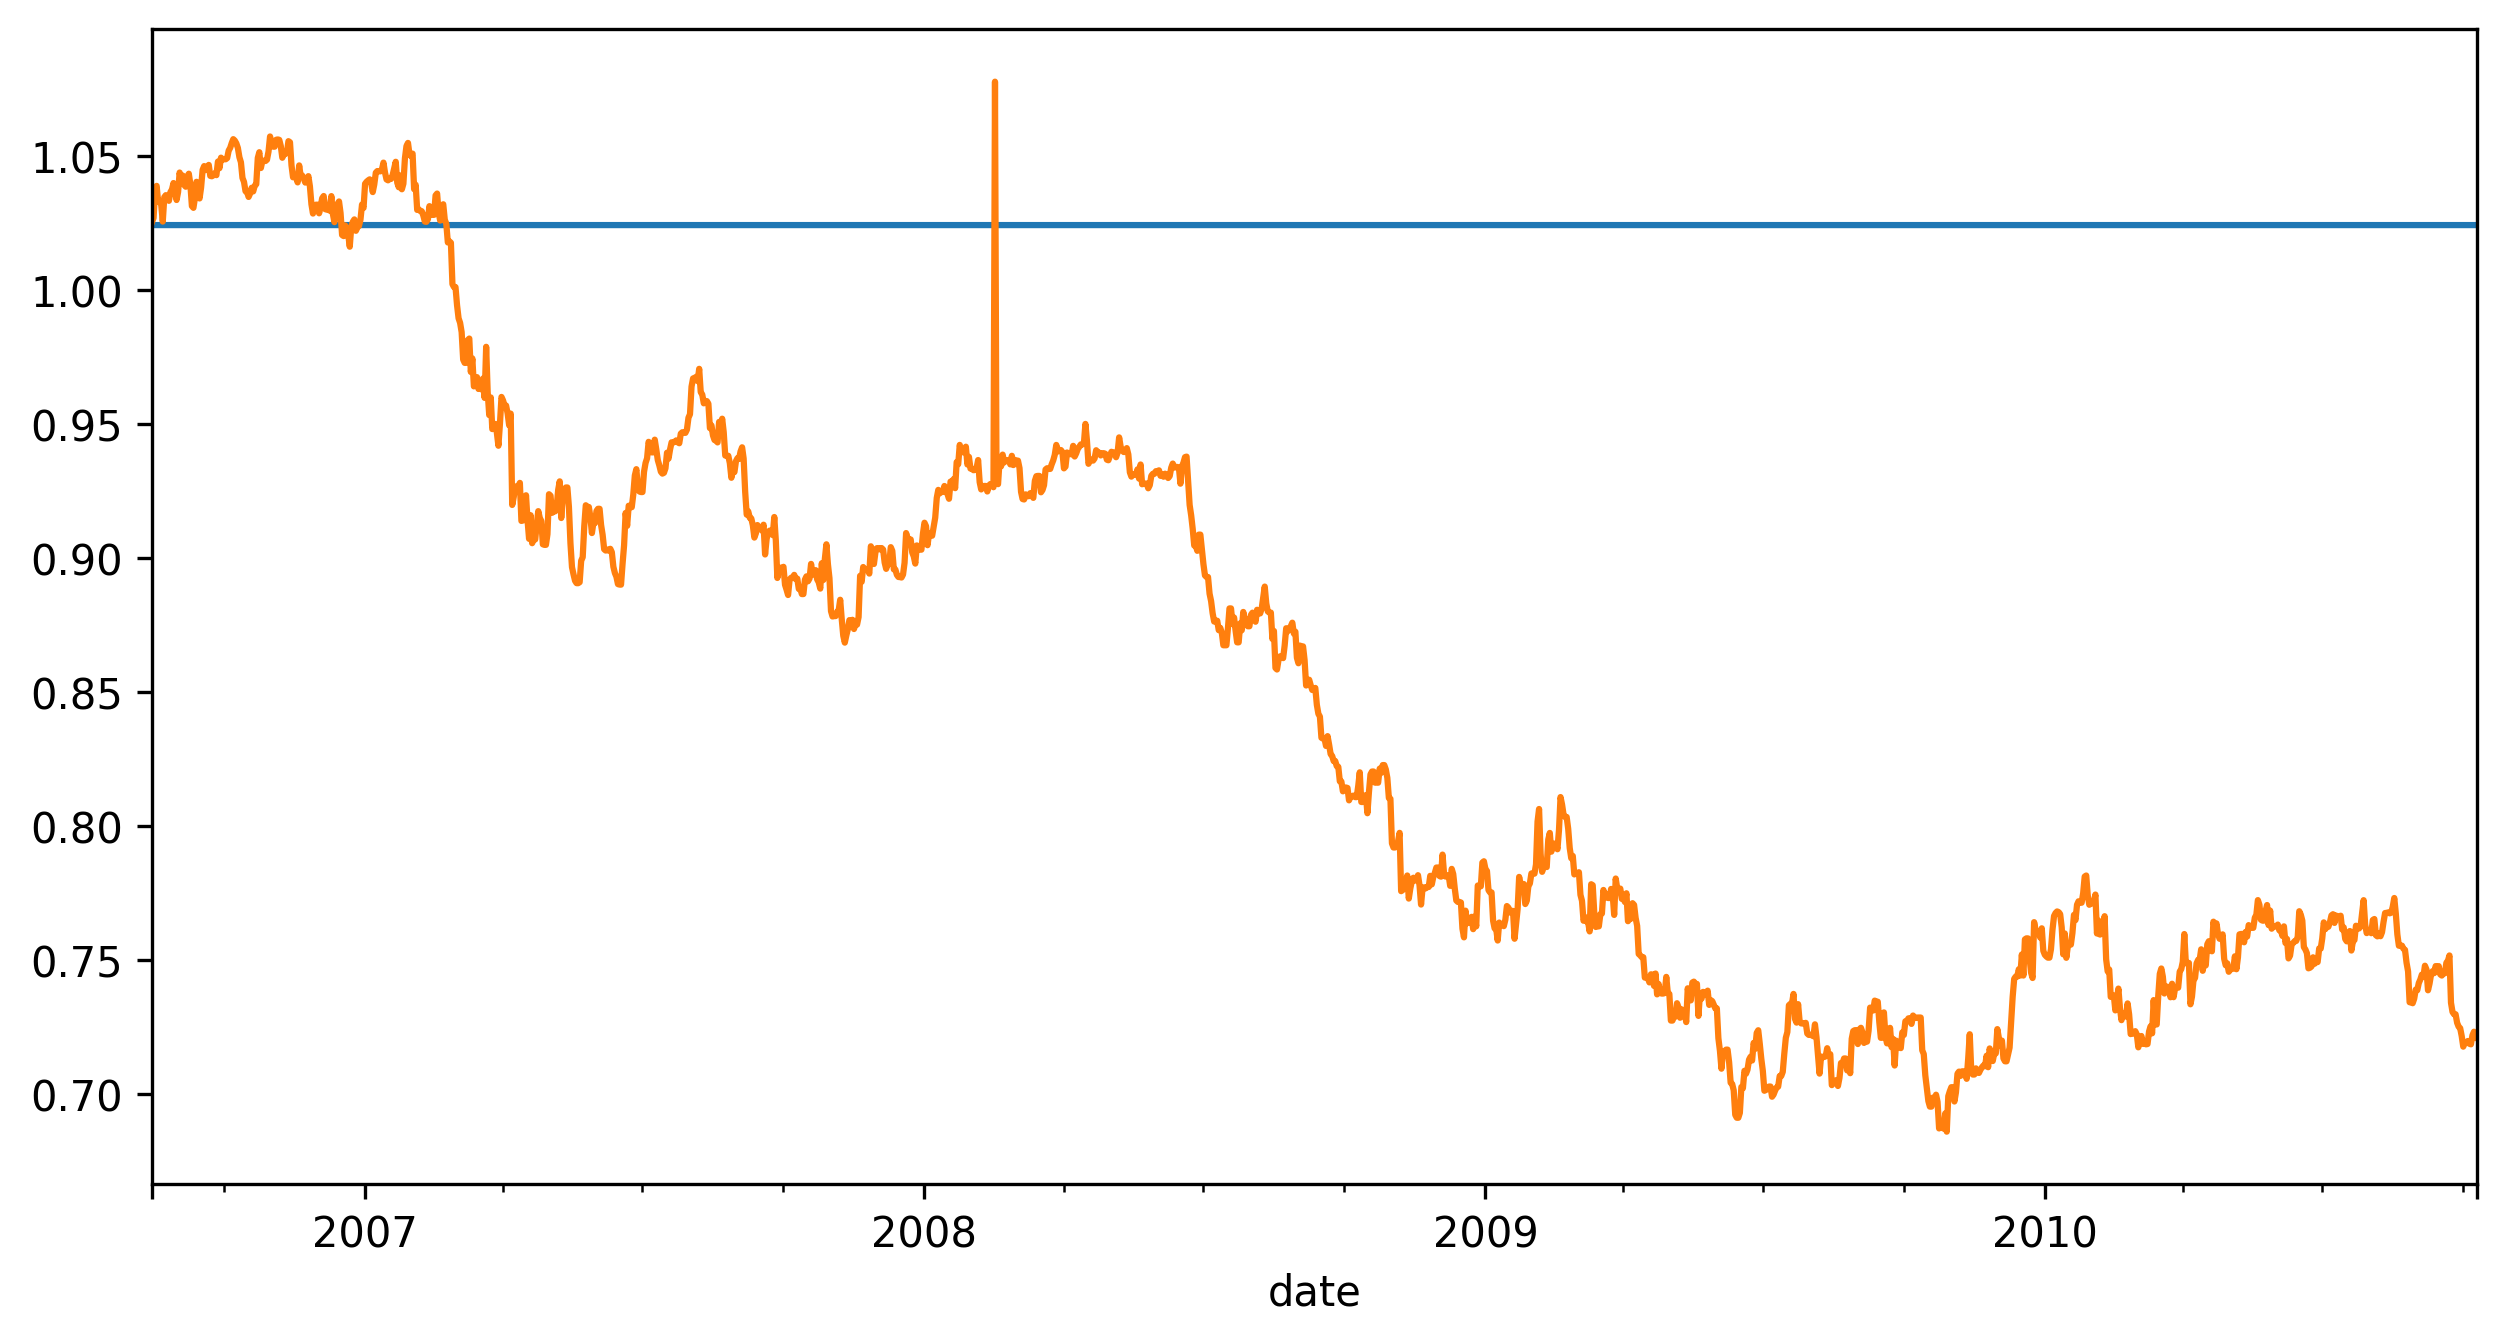

In [29]:
forecast.plot()
test['Ex_rate'].plot()

In [30]:
mean_squared_error(test['Ex_rate'], forecast)

0.04241394796664186

In [31]:
# Holt's Linear Trend model
model3 = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None)
model3_fit = model3.fit(smoothing_level=0.2, smoothing_slope=0.2, optimized=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [32]:
forecast = model3_fit.forecast(len(test))

<Axes: xlabel='date'>

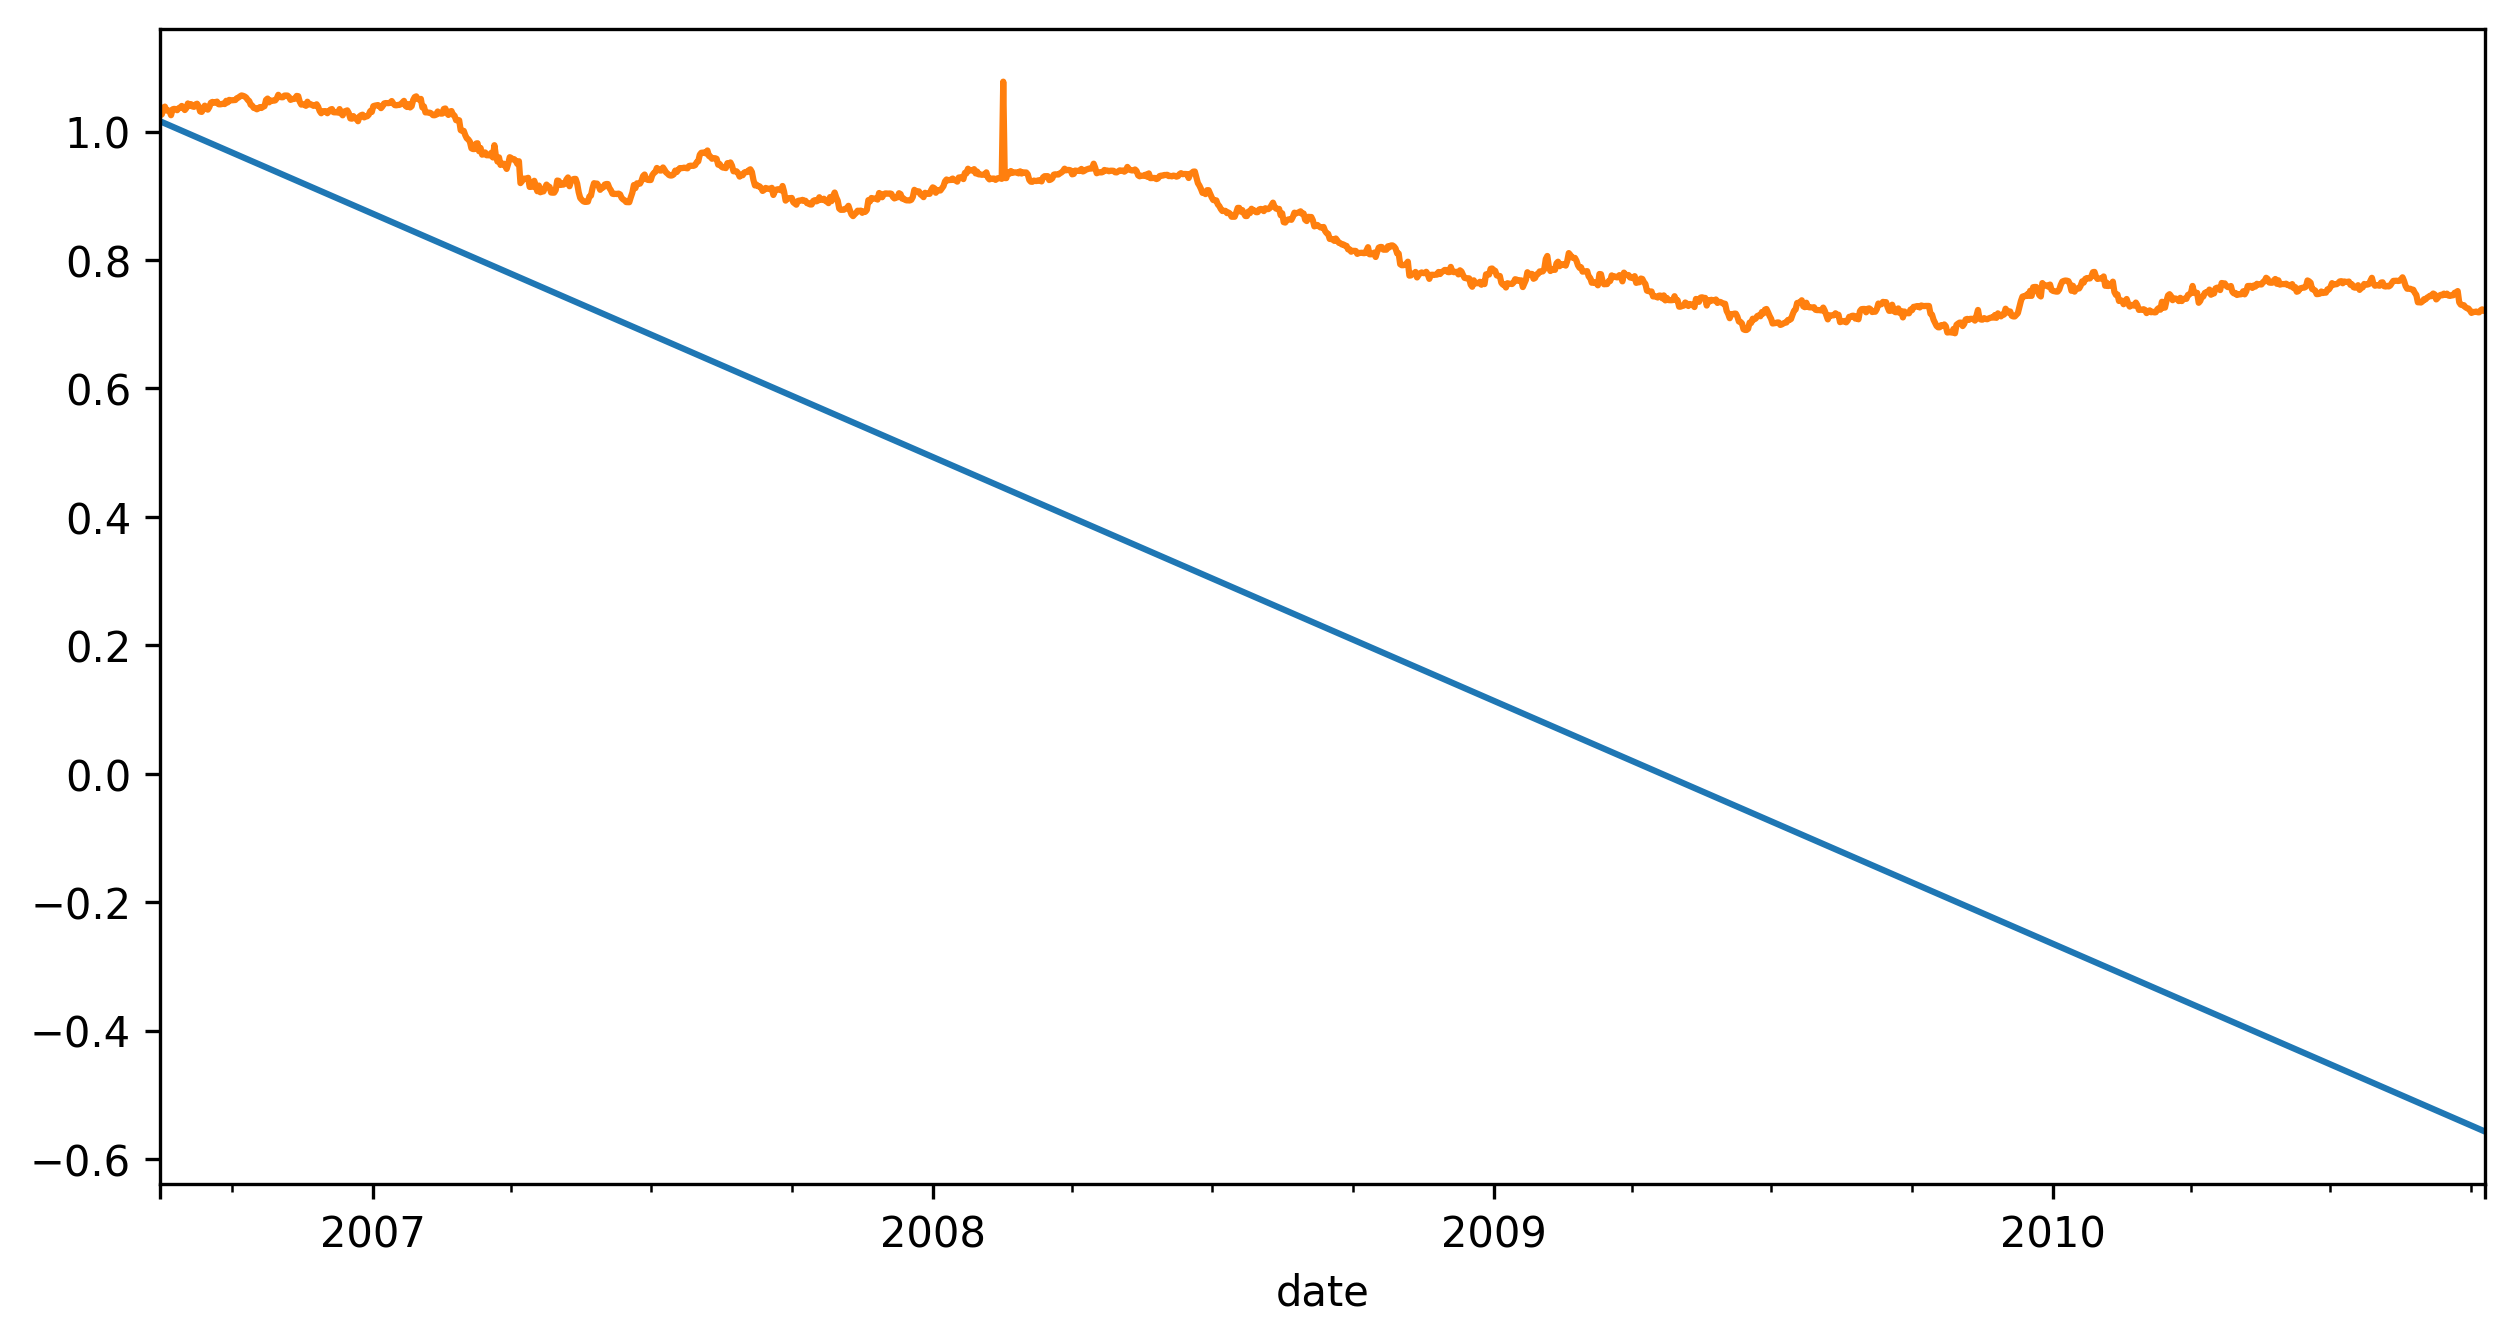

In [33]:
forecast.plot()
test['Ex_rate'].plot()

In [34]:
mean_squared_error(test['Ex_rate'], forecast)

0.5123144984652185

In [35]:
# Holt-Winters Seasonal Model
model4 = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
model4_fit = model4.fit(smoothing_level=0.2, smoothing_slope=0.2, smoothing_seasonal=0.2, optimized=False)
forecast = model4_fit.forecast(len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='date'>

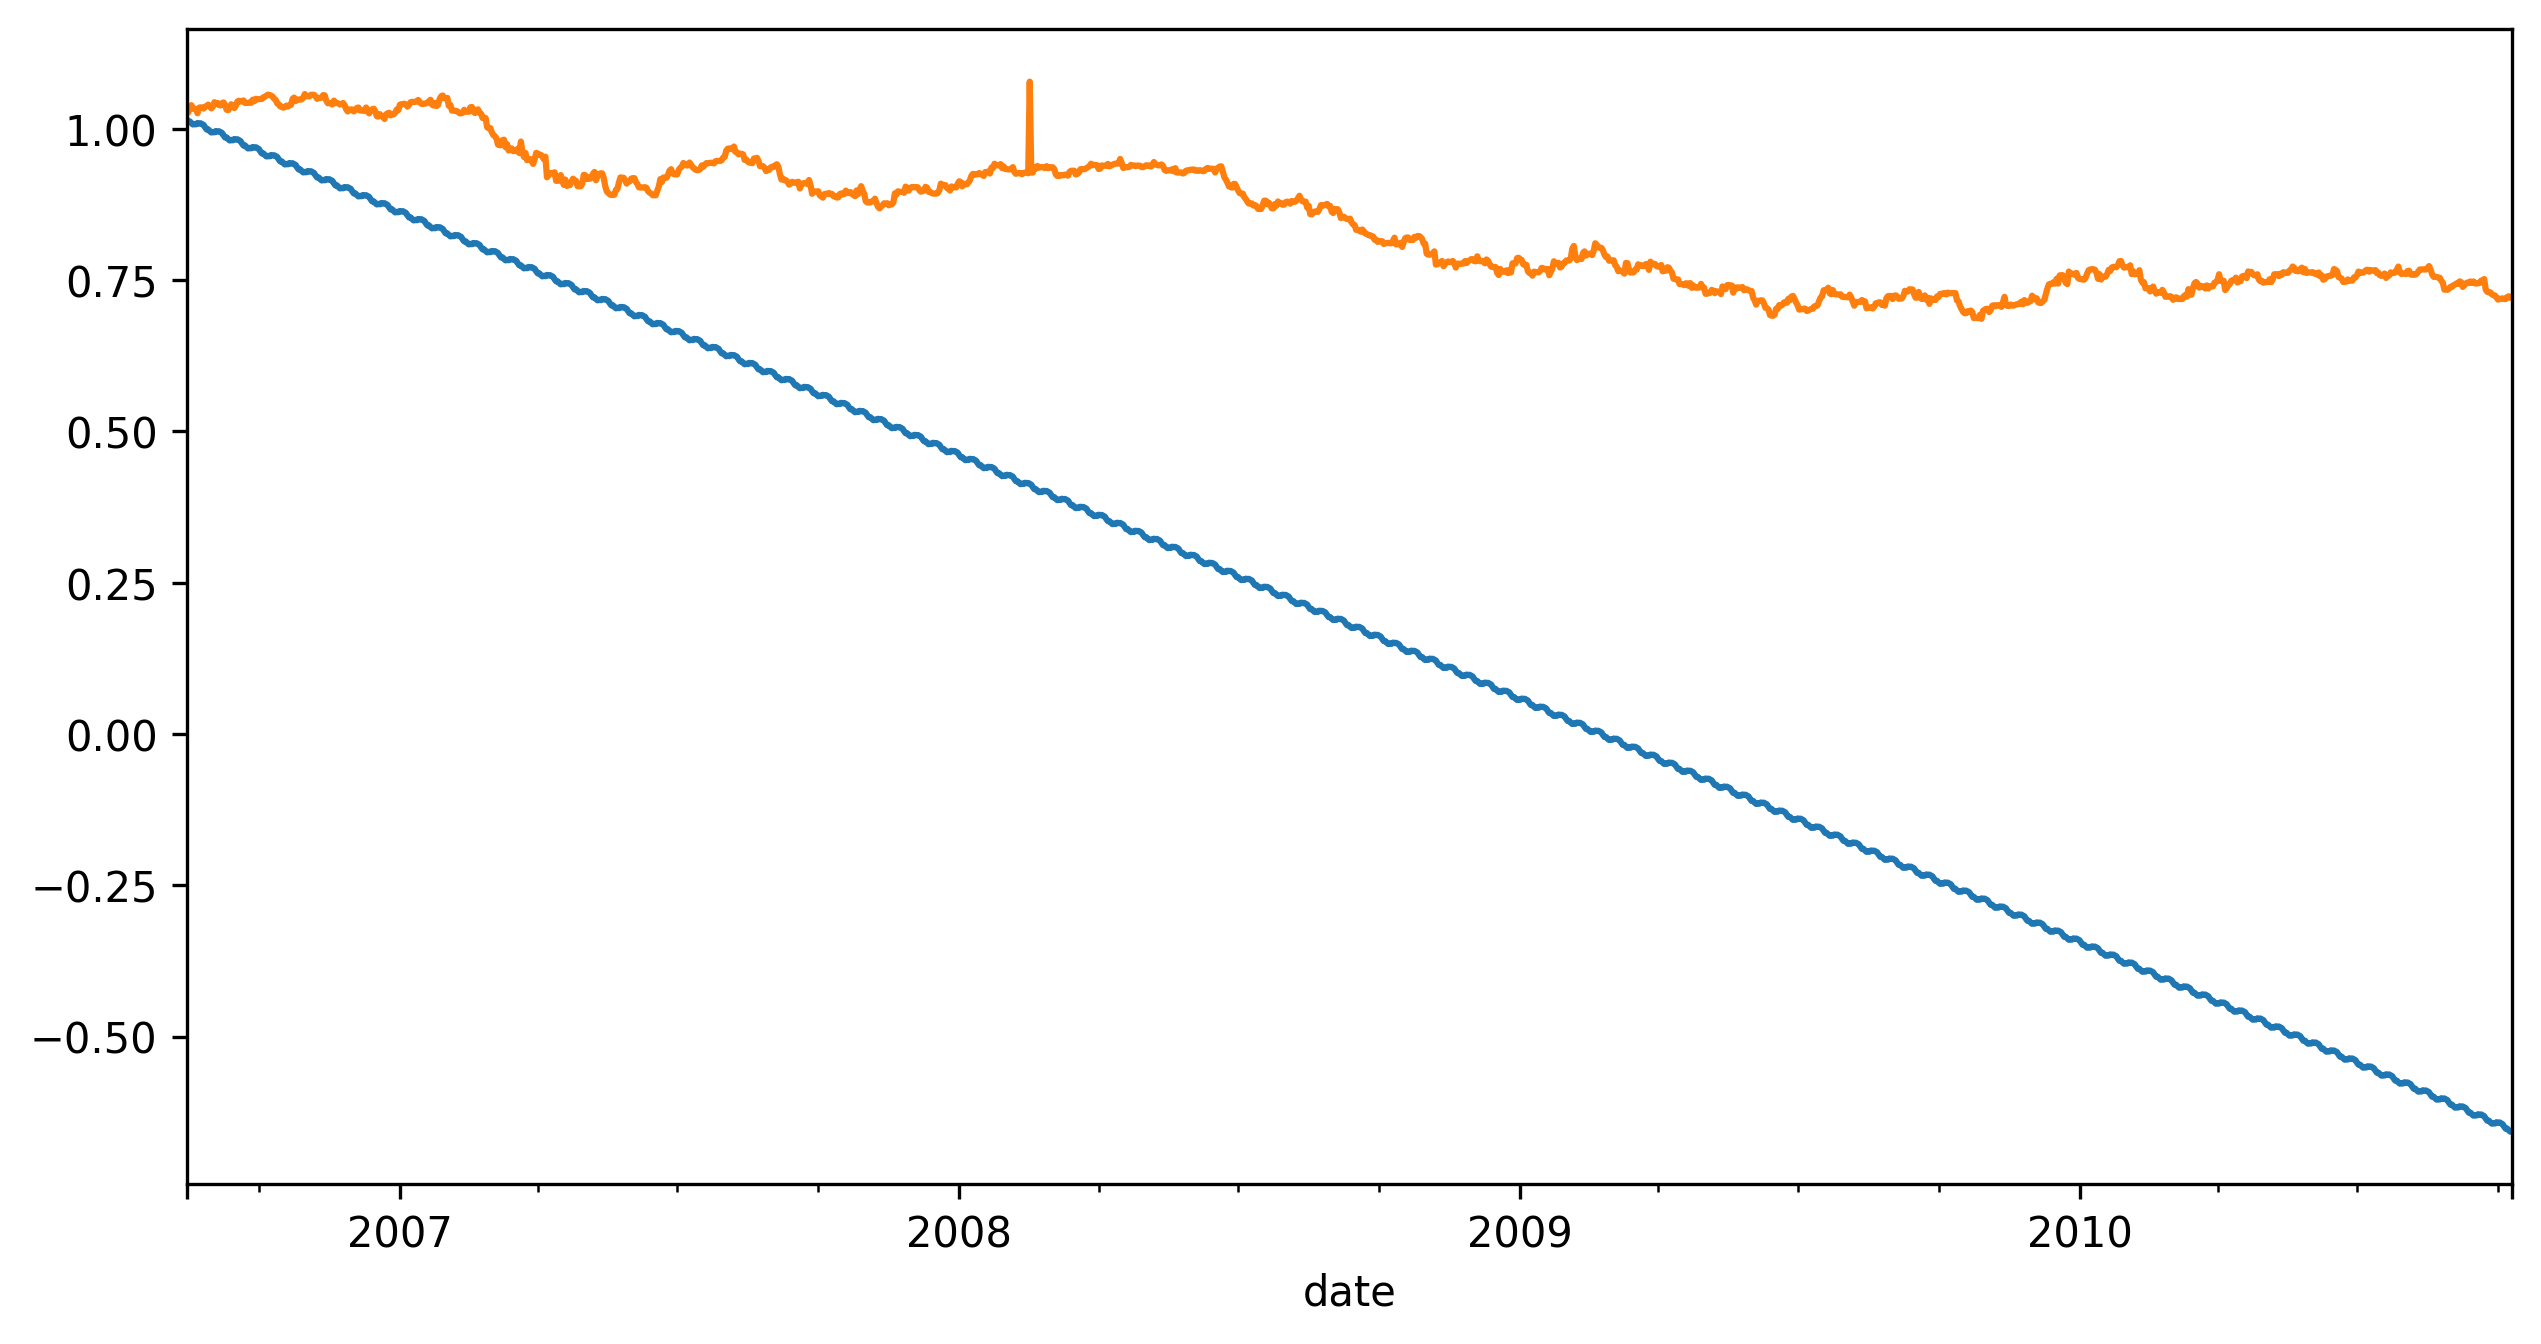

In [36]:
forecast.plot()
test['Ex_rate'].plot()

In [37]:
mean_squared_error(test['Ex_rate'], forecast)

0.5955129534195898

# Hyper parameter tuning

In [38]:
train.drop(columns='First-order', inplace=True)
test.drop(columns='First-order', inplace=True)

In [39]:
# Define the hyperparameter grid
smoothing_level_grid = [0.1, 0.2, 0.3, 0.4, 0.5]
smoothing_slope_grid = [0.1, 0.2, 0.3, 0.4, 0.5]
smoothing_seasonal_grid = [0.1, 0.2, 0.3, 0.4, 0.5]

# To store the best parameters and corresponding RMSE
best_rmse = float('inf')
best_params = {}
i=0

# Loop through all combinations of parameters
for smoothing_level in smoothing_level_grid:
    for smoothing_slope in smoothing_slope_grid:
        for smoothing_seasonal in smoothing_seasonal_grid:
            # Fit the model using the current parameter set
            model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
            try:
                model_fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, smoothing_seasonal=smoothing_seasonal)
                # Make predictions on the test set
                forecast = model_fit.forecast(steps=len(test))

                i=i+1
                print(f'Pass {i} {smoothing_level} {smoothing_slope} {smoothing_seasonal}')

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(test, forecast))

                # If current RMSE is the lowest, store the parameters
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'smoothing_level': smoothing_level,
                        'smoothing_slope': smoothing_slope,
                        'smoothing_seasonal': smoothing_seasonal
                    }
            except:
                continue  # Skip invalid parameter combinations


# Print the best parameters and corresponding RMSE
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 1 0.1 0.1 0.1
Pass 2 0.1 0.1 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 3 0.1 0.1 0.3
Pass 4 0.1 0.1 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 5 0.1 0.1 0.5
Pass 6 0.1 0.2 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 7 0.1 0.2 0.2
Pass 8 0.1 0.2 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 9 0.1 0.2 0.4
Pass 10 0.1 0.2 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 11 0.1 0.3 0.1
Pass 12 0.1 0.3 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 13 0.1 0.3 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 14 0.1 0.3 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 15 0.1 0.3 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 16 0.1 0.4 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 17 0.1 0.4 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 18 0.1 0.4 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 19 0.1 0.4 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 20 0.1 0.4 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 21 0.1 0.5 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 22 0.1 0.5 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 23 0.1 0.5 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 24 0.1 0.5 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 25 0.1 0.5 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 26 0.2 0.1 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 27 0.2 0.1 0.2
Pass 28 0.2 0.1 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 29 0.2 0.1 0.4
Pass 30 0.2 0.1 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 31 0.2 0.2 0.1
Pass 32 0.2 0.2 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 33 0.2 0.2 0.3
Pass 34 0.2 0.2 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 35 0.2 0.2 0.5
Pass 36 0.2 0.3 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 37 0.2 0.3 0.2
Pass 38 0.2 0.3 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 39 0.2 0.3 0.4
Pass 40 0.2 0.3 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 41 0.2 0.4 0.1
Pass 42 0.2 0.4 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 43 0.2 0.4 0.3
Pass 44 0.2 0.4 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 45 0.2 0.4 0.5
Pass 46 0.2 0.5 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 47 0.2 0.5 0.2
Pass 48 0.2 0.5 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 49 0.2 0.5 0.4
Pass 50 0.2 0.5 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 51 0.3 0.1 0.1
Pass 52 0.3 0.1 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 53 0.3 0.1 0.3
Pass 54 0.3 0.1 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 55 0.3 0.1 0.5
Pass 56 0.3 0.2 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 57 0.3 0.2 0.2
Pass 58 0.3 0.2 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 59 0.3 0.2 0.4
Pass 60 0.3 0.2 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 61 0.3 0.3 0.1
Pass 62 0.3 0.3 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 63 0.3 0.3 0.3
Pass 64 0.3 0.3 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 65 0.3 0.3 0.5
Pass 66 0.3 0.4 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 67 0.3 0.4 0.2
Pass 68 0.3 0.4 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 69 0.3 0.4 0.4
Pass 70 0.3 0.4 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 71 0.3 0.5 0.1
Pass 72 0.3 0.5 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 73 0.3 0.5 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 74 0.3 0.5 0.4
Pass 75 0.3 0.5 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 76 0.4 0.1 0.1
Pass 77 0.4 0.1 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 78 0.4 0.1 0.3
Pass 79 0.4 0.1 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 80 0.4 0.1 0.5
Pass 81 0.4 0.2 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 82 0.4 0.2 0.2
Pass 83 0.4 0.2 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 84 0.4 0.2 0.4
Pass 85 0.4 0.2 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 86 0.4 0.3 0.1
Pass 87 0.4 0.3 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 88 0.4 0.3 0.3
Pass 89 0.4 0.3 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 90 0.4 0.3 0.5
Pass 91 0.4 0.4 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 92 0.4 0.4 0.2
Pass 93 0.4 0.4 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 94 0.4 0.4 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 95 0.4 0.4 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 96 0.4 0.5 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 97 0.4 0.5 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 98 0.4 0.5 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 99 0.4 0.5 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 100 0.4 0.5 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 101 0.5 0.1 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 102 0.5 0.1 0.2
Pass 103 0.5 0.1 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 104 0.5 0.1 0.4
Pass 105 0.5 0.1 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 106 0.5 0.2 0.1
Pass 107 0.5 0.2 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 108 0.5 0.2 0.3
Pass 109 0.5 0.2 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 110 0.5 0.2 0.5
Pass 111 0.5 0.3 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 112 0.5 0.3 0.2
Pass 113 0.5 0.3 0.3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 114 0.5 0.3 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 115 0.5 0.3 0.5
Pass 116 0.5 0.4 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 117 0.5 0.4 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 118 0.5 0.4 0.3
Pass 119 0.5 0.4 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 120 0.5 0.4 0.5


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 121 0.5 0.5 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 122 0.5 0.5 0.2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Pass 123 0.5 0.5 0.3
Pass 124 0.5 0.5 0.4


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Pass 125 0.5 0.5 0.5
Best RMSE: 0.043622716827130176
Best Parameters: {'smoothing_level': 0.4, 'smoothing_slope': 0.2, 'smoothing_seasonal': 0.5}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [40]:
model_fit = model.fit(smoothing_level=0.4, smoothing_slope=0.2, smoothing_seasonal=0.5)
# Make predictions on the test set
forecast = model_fit.forecast(steps=len(test))

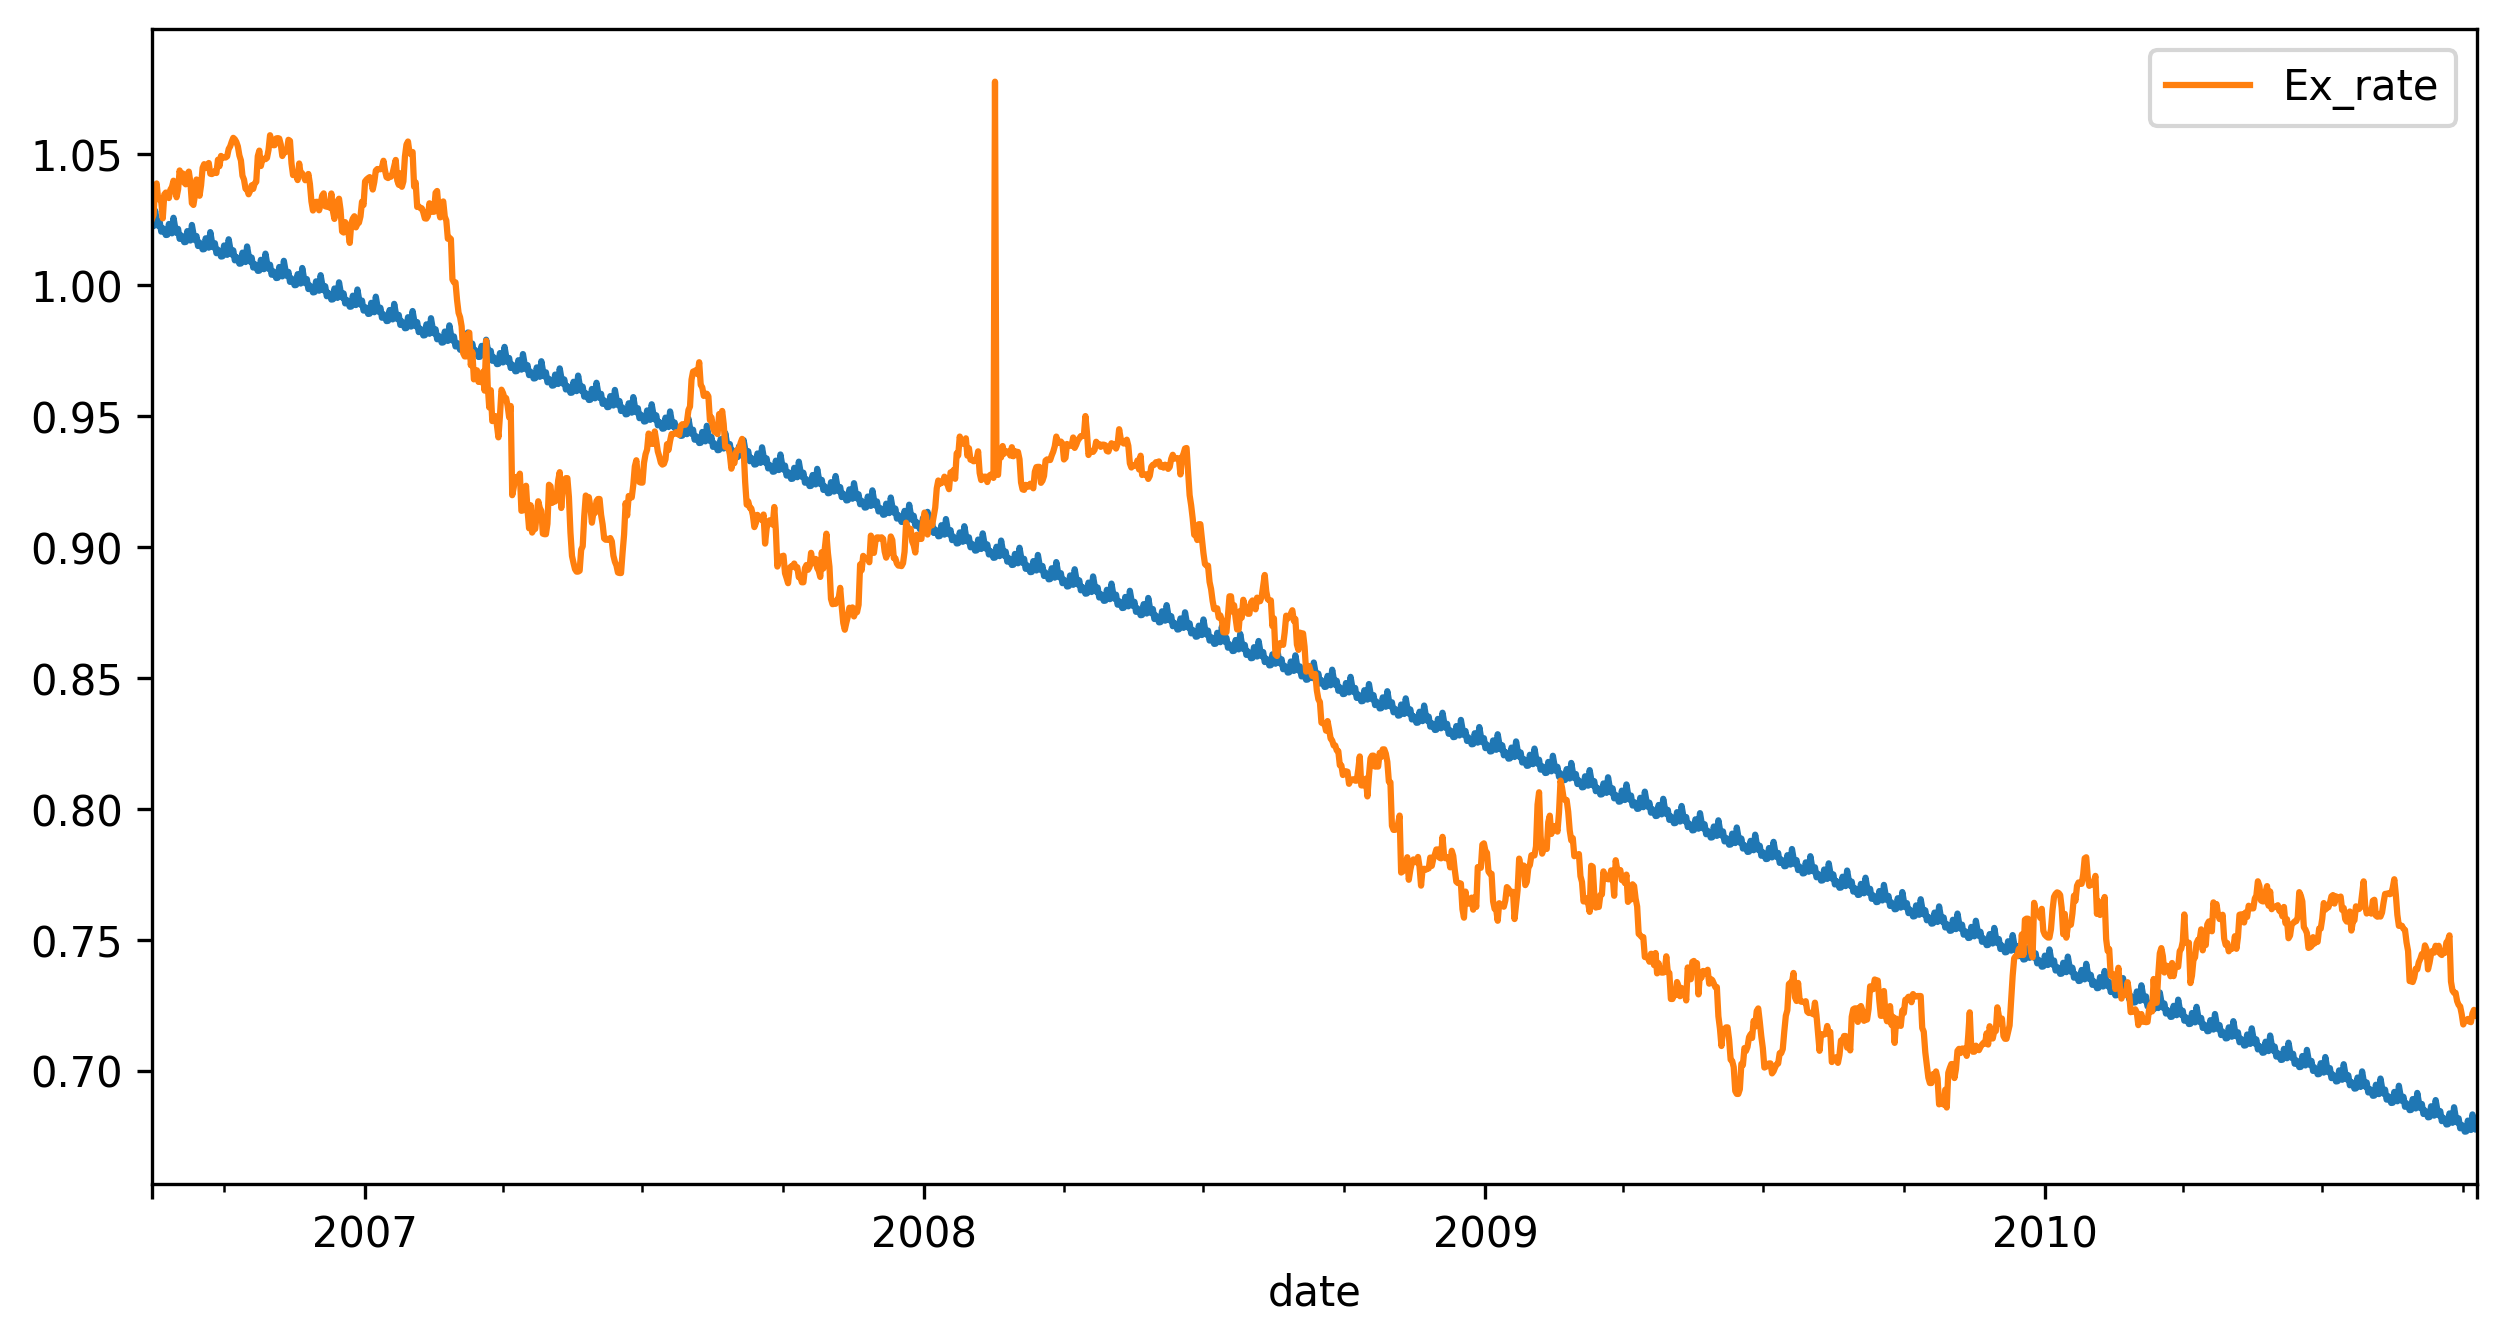

In [41]:
forecast.plot()
test['Ex_rate'].plot()
plt.legend()

In [44]:
rmse_report = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'RMSE': [0.205, 0.04]
})

rmse_report

,Model,RMSE
0,ARIMA,0.205
1,Exponential Smoothing,0.040


From the different RMSE values for both the ARIMA and Exponential smoothing models, we see that the latter performs slighlty better than the former.

Advantages of ARIMA model:
1. Flexibility: ARIMA can model various types of time series (stationary and non-stationary) by incorporating three components: autoregressive (AR), integrated (I), and moving average (MA).
2. Capability to handle trends: ARIMA is designed to capture trends and patterns in time series data, making it effective for data that shows clear trends over time.
3. Stationarity Handling: ARIMA can handle non-stationary data through differencing, which makes it versatile in adjusting for trends and seasonality.
4. Forecasting Performance: It often performs well with short-term forecasts for non-seasonal data.

Limitations of ARIMA model:
1. Complexity in Model Selection: Choosing the right values for the parameters (p, d, q) can be complex, and requires significant domain knowledge or trial and error.
2. Stationarity Requirement: Although ARIMA can handle non-stationary data by differencing, the method works best when the data is stationary or can be made stationary.
3. Poor for Seasonal Data: ARIMA on its own doesn't handle seasonality well; for seasonal time series, Seasonal ARIMA (SARIMA) is required, which adds additional complexity.
4. Assumes Linearity: ARIMA models assume that the relationships between variables are linear, limiting its application to non-linear data.

Advantages of Exponential Smoothing model:
1. Simplicity: Exponential smoothing is simpler to implement and interpret compared to ARIMA. It is often the go-to for quick and straightforward forecasts.
2. Handles Trends and Seasonality (ETS): With variations like Holt’s linear trend method or Holt-Winters seasonal method (ETS), it can capture trends and seasonality.
3. Efficient for short-term forecasting: It works well for short-term forecasts and is often computationally lighter compared to ARIMA.
4. Less Data Preprocessing: Unlike ARIMA, exponential smoothing doesn’t require the data to be stationary, which reduces the amount of preprocessing.

Limitations of Exponential Smoothing model:
1. Limited Complexity Handling: Exponential smoothing doesn't handle complex relationships or long-term trends as well as ARIMA. It is better suited for simple data structures.
2. Doesn’t Model Relationships Explicitly: Unlike ARIMA, which models the autocorrelation between observations, exponential smoothing doesn't explicitly model underlying data structures or correlations.
3. Sensitivity to Outliers: It can be more sensitive to outliers, which might skew forecasts.
4. Requires Adjustment for Seasonal Data: While there are extensions (e.g., Holt-Winters), exponential smoothing by itself doesn't handle seasonality unless specifically adjusted.